In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def decToRad(dec):
    return float(dec)/180*math.pi

def HMStoDeg(h:float,m:float,s:float,convert=False):
    try: h,m,s=float(h),float(m),float(s)
    except: raise Exception("Values must be floats")
    res = h*15 + m/60*15 + s/3600*15
    res%=360
    return decToRad(res) if convert else res

def DMStoDeg(d:float,arcm:float,arcs:float,convert=False)->float:
    return decToRad(math.copysign(abs(d)+arcm/60+arcs/3600,d)) if convert else math.copysign(abs(d)+arcm/60+arcs/3600,d)

def RAdecimalToHMS(dec:float)->tuple:
    dec%=360
    h=dec/15
    m=(dec%15)/15*60
    s=m%1*60
    h//=1
    m//=1
    #print((h,m,s))
    return (h,m,s)

def DECdecimalToDMS(dec:float)->tuple:
    d=math.trunc(dec)
    dec=abs(dec)-abs(d)
    m=math.trunc(dec*60)
    dec-=m/60
    s=dec*3600
    if (round(s,0)-s<0.00001):s=round(s,0)
    #print((d,m,s))
    return (d,m,s)

In [6]:
def det3x3(m):
    return m[0,0]*(m[1,1]*m[2,2] - m[1,2]*m[2,1]) - m[0,1]*(m[1,0]*m[2,2] - m[1,2]*m[2,0]) + m[0,2]*(m[1,0]*m[2,1] - m[1,1]*m[2,0])

def spliceCol(m,c,j):
    '''
    m: 3x3 coefficent matrix
    c: 3x1 constant column
    j: column num
    '''
    res=np.copy(m)
    res[:,j]=c
    return res

def cramer(m,c):
    '''
    m: 3x3 coefficent matrix
    c: 3x1 constant column
    '''
    return (det3x3(spliceCol(np.copy(m),c,0))/det3x3(m), det3x3(spliceCol(np.copy(m),c,1))/det3x3(m), det3x3(spliceCol(np.copy(m),c,2))/det3x3(m))



Object (asteroid) coords:
20.0 hr 43 min 34.227 sec
-5 deg 32 min 33.897 sec

[-0.0040243564929483, 0.000700965167936829, 0.005780937377721784, -0.0021308722847948047, -0.004945178238301651, 0.004618504450490946]
[0.001054053659241383, -0.0002224103489005813, -0.0014419690765583582, 0.0005257852977544886, 0.0012546741106183035, -0.0011701336421348074]
star	RA Res(s)	Dec Res(s)
1	-14.4877  	3.7946
2	2.5235  	-0.8007
3	20.8114  	-5.1911
4	-7.6711  	1.8928
5	-17.8026  	4.5168
6	16.6266  	-4.2125

sigmaRA(s): 20.829458 
sigmaDec(s): 5.28258


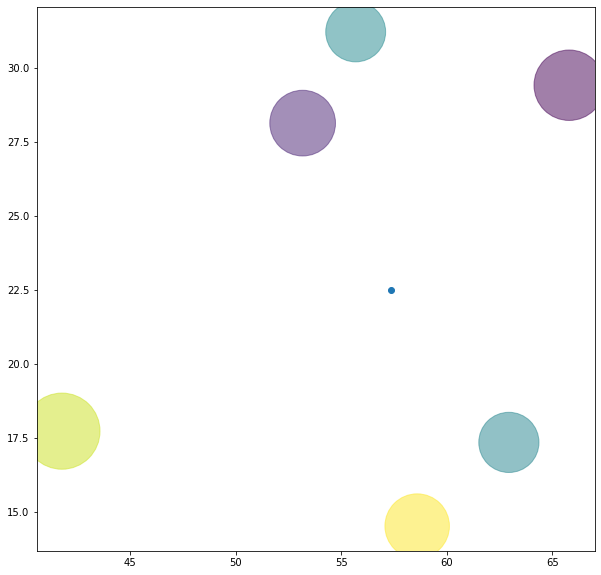

In [17]:
def lspr():
    # format info
    data=np.loadtxt("/home/soonali/Documents/LSPRData.csv",dtype=str,delimiter=None)
    stars=np.zeros((len(data)-2,5))
    for line in range(1,len(data)-1):
        ra=HMStoDeg(float(data[line][2]), float(data[line][3]), float(data[line][4]))
        dec=DMStoDeg(float(data[line][5]), float(data[line][6]), float(data[line][7]))
        stars[line-1,:]=np.array([float(data[line][0]),float(data[line][1]),ra,dec,float(data[line][8])])
    asx,asy=float(data[len(data)-1][0]),float(data[len(data)-1][1])
    #print(data)
    
    N=len(stars)
    sumX=np.sum(stars[:,0])
    sumY=np.sum(stars[:,1])
    sumProdXY=sum([stars[i,0]*stars[i,1] for i in range(N)])
    sumXSq=sum([stars[i,0]*stars[i,0] for i in range(N)])
    sumYSq=sum([stars[i,1]*stars[i,1] for i in range(N)])
    sumRA=np.sum(stars[:,2])
    sumDec=np.sum(stars[:,3])
    sumProdRAX=sum([stars[i,2]*stars[i,0] for i in range(N)])
    sumProdRAY=sum([stars[i,2]*stars[i,1] for i in range(N)])
    sumProdDecX=sum([stars[i,3]*stars[i,0] for i in range(N)])
    sumProdDecY=sum([stars[i,3]*stars[i,1] for i in range(N)])
    
    m=np.array([[N,sumX,sumY],[sumX,sumXSq,sumProdXY],[sumY,sumProdXY,sumYSq]])
    res1=cramer(m,np.array([sumRA,sumProdRAX,sumProdRAY]))
    b1,a11,a12=res1[0],res1[1],res1[2]
    
    res2=cramer(m,np.array([sumDec,sumProdDecX,sumProdDecY]))
    b2,a21,a22=res2[0],res2[1],res2[2]
    
    #print(sumX,sumY,sumXSq,sumYSq,sumProdXY,sumRA,sumDec,sumProdDecX,sumProdDecY)
    
    #print(stars)
    #print(asx,asy)
    #print(b1,b2,a11,a12,a21,a22)
    
    # results
    astRA=b1+a11*asx+a12*asy
    astDec=b2+a21*asx+a22*asy
    RAHMS=RAdecimalToHMS(astRA)
    DecDMS=DECdecimalToDMS(astDec)
    print("Object (asteroid) coords:")
    print(str(RAHMS[0])+" hr "+str(int(RAHMS[1]))+" min "+str(round(RAHMS[2],3))+" sec")
    print(str(DecDMS[0])+" deg "+str(DecDMS[1])+" min "+str(round(DecDMS[2],3))+" sec")
    
    print()
    
    resRA = [stars[i,2]-(b1+a11*stars[i,0]+a12*stars[i,1]) for i in range(N)]
    resRASq = sum([(stars[i,2]-(b1+a11*stars[i,0]+a12*stars[i,1]))**2 for i in range(N)])
    resDec = [stars[i,3]-(b2+a21*stars[i,0]+a22*stars[i,1]) for i in range(N)]               
    resDecSq = sum([(stars[i,3]-(b2+a21*stars[i,0]+a22*stars[i,1]))**2 for i in range(N)])
        
    print(resRA)
    print(resDec)
    
    sigmaRA=math.sqrt(resRASq/(N-3))
    sigmaDec=math.sqrt(resDecSq/(N-3))
    
    #print(resRASq,resDecSq)
    #print(sigmaRA,sigmaDec)
    #print(resRA,resDec)
    result=""
    for val in [str(i+1)+"\t"+str(format(resRA[i]*3600,'.4f'))+"  \t"+str(round(resDec[i]*3600,4)) for i in range(N)]:
        result+=val+"\n"
    print("star\tRA Res(s)\tDec Res(s)\n"+result)
    
    
    print("sigmaRA(s):",round(sigmaRA*3600,6),"\nsigmaDec(s):",round(sigmaDec*3600,6))
    

    
    # Fixing random state for reproducibility
    np.random.seed(19680801)
    
    n=N
    x = np.random.rand(n)
    y = np.random.rand(n)
    colors = np.random.rand(n)
    area = 50*np.array([stars[i,4]**2 for i in range(N)])
    x=np.array([stars[i,0] for i in range(N)])
    y=np.array([stars[i,1] for i in range(N)])
    
    plt.figure(figsize=((10,10)))
    plt.scatter(x, y, s=area, c=colors, alpha=0.5)
    plt.scatter(asx,asy)
    plt.show()
    
    
lspr()